In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib


In [2]:
df = pd.read_csv("/kaggle/input/car-salesss/car-sales-extended (1).csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1000, 5)


,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431,4,15323
1,BMW,Blue,192714,5,19943
2,Honda,White,84714,4,28343
3,Toyota,White,154365,4,13434
4,Nissan,Blue,181577,3,14043



Missing values per column:
 Make             0
Colour           0
Odometer (KM)    0
Doors            0
Price            0
dtype: int64

Data types:
 Make             object
Colour           object
Odometer (KM)     int64
Doors             int64
Price             int64
dtype: object


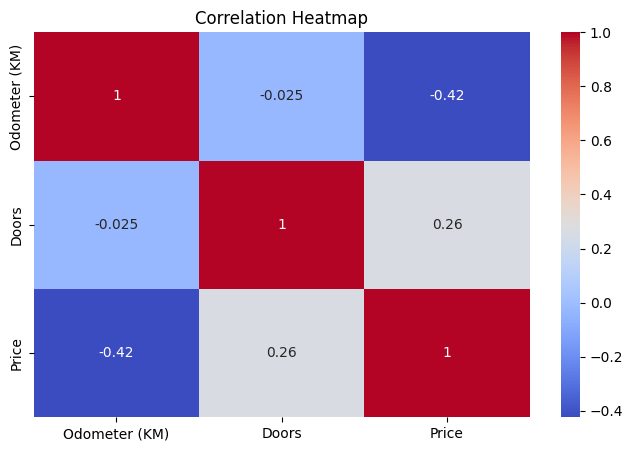

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


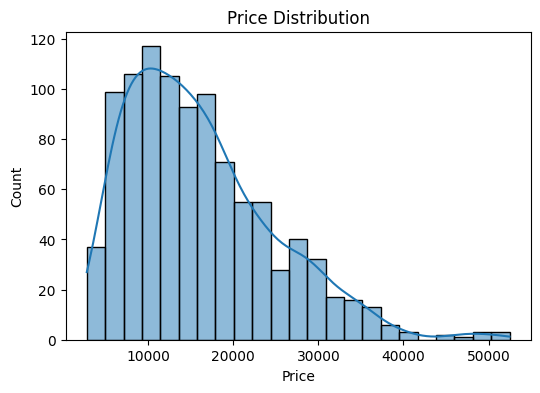

In [3]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df["Price"], kde=True)
plt.title("Price Distribution")
plt.show()


In [4]:
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(exclude=np.number).columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
current_year = 2025
if "Year" in df.columns:
    df["Car_Age"] = current_year - df["Year"]

if "Odometer (KM)" in df.columns:
    df["Price_per_km"] = df["Price"] / (df["Odometer (KM)"] + 1)


In [7]:
X = df.drop("Price", axis=1)
y = df["Price"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
    results[name] = scores.mean()

results_df = pd.DataFrame(results.items(), columns=["Model", "R² Mean CV Score"])
print("\nModel Comparison:\n", results_df.sort_values(by="R² Mean CV Score", ascending=False))



Model Comparison:
                Model  R² Mean CV Score
3            XGBoost          0.966140
2  Gradient Boosting          0.963453
1      Random Forest          0.958132
0  Linear Regression          0.461497


In [9]:
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

rf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                          ("model", RandomForestRegressor(random_state=42))])

grid_search = GridSearchCV(rf_pipe, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X, y)

print("\nBest RF Params:", grid_search.best_params_)
print("Best RF Score:", grid_search.best_score_)



Best RF Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF Score: 0.956399339225336


In [10]:
final_model = grid_search.best_estimator_
final_model.fit(X, y)

joblib.dump(final_model, "car_price_model.pkl")
print("Model saved as car_price_model.pkl")


Model saved as car_price_model.pkl


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("\nR²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))



R²: 0.9220579652552756
RMSE: 2669.2000878538033
MAE: 1058.3011


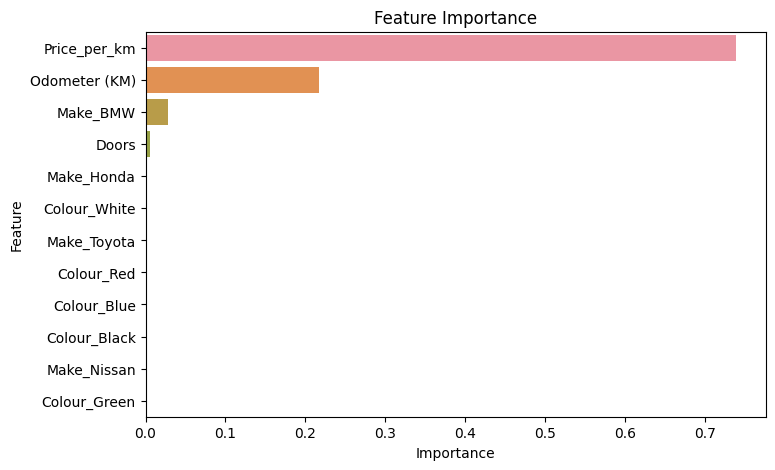

In [12]:
if hasattr(final_model.named_steps["model"], "feature_importances_"):
    feature_names = (numerical_cols +
                     list(final_model.named_steps["preprocessor"]
                          .transformers_[1][1]
                          .get_feature_names_out(categorical_cols)))
    importances = final_model.named_steps["model"].feature_importances_
    feat_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feat_df = feat_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x="Importance", y="Feature", data=feat_df)
    plt.title("Feature Importance")
    plt.show()
